## Quantifying Inter-Order Overlap in Real-World Hypergraphs

We analyze several real-world datasets and quantify their **structural organization** using the **inter-order overlap** metric introduced in Eq. (1) of the main text. This metric measures the fraction of **lower-order hyperedges** that are fully embedded in **higher-order hyperedges**, reflecting the extent to which interactions of different orders are structurally correlated.

To systematically characterize inter-order overlap across all combinations of hyperedge orders, we employ the **Overlap Matrix** \(A\) introduced in [1], defined as:

$
A =
\begin{bmatrix}
0 & \alpha_{1,2} & \alpha_{1,3} & \cdots & \alpha_{1,M} \\
0 & 0 & \alpha_{2,3} & \cdots & \alpha_{2,M} \\
\vdots & \vdots & \ddots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \alpha_{M-1,M} \\
0 & 0 & 0 & \cdots & 0
\end{bmatrix},
$
where:

- \($\alpha_{m,n}$\) denotes the **inter-order overlap** between hyperedges of order \(m\) and \(n\),  
- \($M$\) is the **maximum order** observed in the dataset.  

We **omit diagonal terms**, which would correspond to intra-order overlap, and set \(\alpha_{m,n} = 0\) for all \(m > n\), since inter-order overlap is not defined in these cases.

---

To provide a **single summary metric** for the overall level of inter-order correlation in a hypergraph, we define the **average inter-order hyperedge overlap** as:

$
\langle \alpha \rangle = 
\frac{
\sum_{m=1}^{M-1} \sum_{n=m+1}^{M} \alpha_{m,n} \, |E_m|
}{
\sum_{m=1}^{M-1} \sum_{n=m+1}^{M} |E_m|
},
$

where \(|E_m|\) is the number of hyperedges of order \(m\). This scalar captures the **average structural embedding** of lower-order interactions into higher-order ones across the entire hypergraph.

---

In the following subsections, we:

1. Analyze datasets where **group structures are explicitly provided**, such as emails or biochemical interactions.  
2. Examine **proximity/contact data**, where empirical hypergraphs depend on specific methodological choices (e.g., time window and filtering threshold).  

This approach allows us to explore how different construction methods impact the resulting **inter-order overlap** and overall higher-order structure.



In [1]:
!pip install xgi


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import xgi as xgi
from overlap_func import *

## Import Data

The dataset used in this analysis is sourced from the [**CompleX Group Interactions (XGI)**](https://xgi.readthedocs.io/en/latest/index.html) library.

There are two main ways to import the data:

1. **Directly from the XGI library**  
   You can load datasets directly through the XGI API, which provides built-in functions to access various real-world hypergraph datasets.

2. **From local edge list files**  
   Alternatively, you can load the data from the `edge_lists` files located in the folder **`hyperedge_list_real_data/`**.  
   This folder contains six datasets:  
   - Each file begins with the dataset name in the **first row**.  
   - The following rows list the **members of each hyperedge**, separated by spaces.

In [10]:
# -------------------------------------------------------------
# Import hypergraph datasets directly from the XGI library
# -------------------------------------------------------------

import xgi

# List of available dataset names from the XGI library
datasets = [
    "contact-primary-school",
    "email-enron",
    "email-eu",
    "congress-bills",
    "tags-ask-ubuntu",
    "diseasome",
    "ndc-substances"
]

# Initialize a list to store the loaded hypergraphs
H_originals = []

# Load each dataset using xgi.load_xgi_data() and store it in the list
for name in datasets:
    H = xgi.load_xgi_data(name)
    H_originals.append(H)
    print(f"Loaded dataset: {name} ({len(H.edges)} hyperedges, {len(H.nodes)} nodes)")

Loaded dataset: contact-primary-school (106879 hyperedges, 242 nodes)
Loaded dataset: email-enron (10885 hyperedges, 148 nodes)
Loaded dataset: email-eu (235263 hyperedges, 1005 nodes)
Loaded dataset: congress-bills (282049 hyperedges, 1718 nodes)
Loaded dataset: tags-ask-ubuntu (271233 hyperedges, 3029 nodes)
Loaded dataset: diseasome (903 hyperedges, 516 nodes)
Loaded dataset: ndc-substances (112919 hyperedges, 5556 nodes)


In [11]:
# -------------------------------------------------------------
# Alternative to previouse cell: Import hypergraph datasets from local edge list files
# -------------------------------------------------------------

import xgi

# Initialize a list to store the loaded hypergraphs
H_originals = []

# Loop over the dataset files (assuming 7 local files)
for i in range(7):
    dataset_name = None
    edge_list = []

    # Read the dataset file
    file_path = f"hyperedge_list_real_data/data_set_{i}.txt"
    with open(file_path, "r") as f:
        for j, line in enumerate(f):
            if j == 0:
                # First line contains the dataset name
                dataset_name = line.strip()
            else:
                # Each subsequent line represents a hyperedge
                edge = line.strip().split()
                edge_list.append(edge)

    # Create a hypergraph from the edge list
    H = xgi.Hypergraph(edge_list)
    H_originals.append(H)

    print(f"Loaded dataset: {dataset_name} ({len(H.edges)} hyperedges, {len(H.nodes)} nodes)")

Loaded dataset: contact-primary-school (106879 hyperedges, 242 nodes)
Loaded dataset: email-enron (10885 hyperedges, 143 nodes)
Loaded dataset: email-eu (235263 hyperedges, 1005 nodes)
Loaded dataset: congress-bills (282049 hyperedges, 1718 nodes)
Loaded dataset: tags-ask-ubuntu (271233 hyperedges, 3029 nodes)
Loaded dataset: diseasome (903 hyperedges, 516 nodes)
Loaded dataset: ndc-substances (112919 hyperedges, 5556 nodes)


## 📊 Information about the Datasets

Below is an overview of the datasets used in this analysis, including a description, source, and relevant links for each.

---

### 1. contact-primary-school

**Overview:**  
This dataset is constructed from a contact network among children and teachers at a primary school. Hyperedges are formed through cliques of simultaneous contacts. Specifically, for every unique timestamp, a hyperedge is constructed for each maximal clique among the contact edges that exist at that timestamp. Timestamps were recorded in 20-second intervals.

**Source:** SocioPatterns  
**XGI link:** [https://zenodo.org/records/10155802](https://zenodo.org/records/10155802)  
**Original source:** [SocioPatterns high-school dataset](http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/)

---

### 2. email-enron

**Overview:**  
This is a temporal hypergraph dataset (a sequence of timestamped hyperedges). Each hyperedge is a set of nodes representing an email: the sender and all recipients. Only email addresses from a core set of ~150 Enron employees are included. Timestamps are in ISO8601 format. Invalid addresses were standardized, and some messages removed for redaction.

**Source:** Email-Enron dataset (CALO Project)  
**XGI link:** [https://zenodo.org/records/10155819](https://zenodo.org/records/10155819)  
**Original source:** [Cornell email dataset](https://www.cs.cornell.edu/~arb/data/email-Enron/)

---

### 3. email-EU

**Overview:**  
This temporal hypergraph dataset represents email communication at a large European research institution (Oct 2003–May 2005). Only emails between institution members are included. Each hyperedge is a sender plus all recipients of an email at the same timestamp. Timestamps are ISO8601.

**XGI link:** [https://zenodo.org/records/10155823](https://zenodo.org/records/10155823)  
**Original source:** [Cornell email-EU dataset](https://www.cs.cornell.edu/~arb/data/email-Eu/)

---

### 4. congress-bills

**Overview:**  
Temporal hypergraph dataset where nodes are US Congresspersons. Hyperedges represent sponsors and co-sponsors of bills in both the House and Senate. Timestamps are in ISO8601.

**XGI link:** [https://zenodo.org/records/10928561](https://zenodo.org/records/10928561)  
**Original source:** [Congress bills dataset](https://www.cs.cornell.edu/~arb/data/congress-bills/)

---

### 5. tags-ask-ubuntu

**Overview:**  
Temporal higher-order network dataset of askubuntu.com users. Hyperedges represent users participating in the same thread within 24 hours. Timestamps are normalized such that the earliest post starts at 0.

**XGI link:** [https://zenodo.org/records/10373311](https://zenodo.org/records/10373311)  
**Original source:** [Ask Ubuntu thread dataset](https://www.cs.cornell.edu/~arb/data/threads-ask-ubuntu/)

---

### 6. diseasome

**Overview:**  
Dataset of diseases and their associated genes. Nodes are diseases, hyperedges are genes. Node and edge labels provide disease and gene names, respectively. Only disease-gene relationships are retained.

**Source:** Gephi  
**XGI link:** [https://zenodo.org/records/10155812](https://zenodo.org/records/10155812)  
**Original source:** [Gephi diseasome dataset](https://github.com/gephi/gephi.github.io/blob/master/datasets/diseasome.gexf.zip)

---

### 7. ndc-substances

**Overview:**  
Temporal higher-order network of drugs and their chemical substances (U.S. FDA NDC Directory). Each hyperedge corresponds to an NDC code, and nodes are the substances in the drug. Timestamps represent the day the drug was first marketed. Hyperedges are limited to ≤25 nodes.

**Source:** NDC-substances  
**XGI link:** [https://zenodo.org/records/10929019](https://zenodo.org/records/10929019)  
**Original source:** [Cornell NDC dataset](https://www.cs.cornell.edu/~arb/data/NDC-substances/)


## Clean the hypergfraphs:

To continue with the analysis we first need to clean up the datasets. For this we need to remove, repeated hyperdges and self-loops

In [12]:
# -------------------------------------------------------------
# Clean and analyze hypergraphs loaded from edge lists
# -------------------------------------------------------------

H_s = []  # List to store cleaned hypergraphs

# Loop over all hypergraphs loaded from local edge lists
for i, H_original in enumerate(H_originals):
    
    print('------------------------------------------------------------')
    print(f"Dataset: {datasets[i]}")
    
    # Print original statistics
    print("Original number of edges:", H_original.num_edges)
    
    # Detect isolated nodes
    isolated_nodes = H_original.nodes.isolates()
    print("Number of isolated nodes:", len(isolated_nodes))
    
    # Detect duplicated edges
    duplicated_edges = H_original.edges.duplicates()
    print("Number of duplicated edges:", len(duplicated_edges))
    
    # Clean the hypergraph
    # Parameters:
    # - multiedges=False: keep only one copy of each edge if duplicates exist
    # - singletons=False: keep edges with a single node
    # - isolates=False: keep nodes without edges
    # - relabel=True: relabel nodes to consecutive integers
    # - in_place=False: return a new cleaned hypergraph
    H_clean = H_original.cleanup(
        multiedges=False,
        singletons=False,
        isolates=False,
        relabel=True,
        in_place=False
    )
    
    # Print comparison of original vs cleaned hypergraph
    print("\nOriginal hypergraph:")
    print("Number of nodes:", H_original.num_nodes)
    print("Number of edges:", H_original.num_edges)
    
    print("\nCleaned hypergraph:")
    print("Number of nodes:", H_clean.num_nodes)
    print("Number of edges:", H_clean.num_edges)
    
    # Check connectivity of the cleaned hypergraph
    connected = xgi.is_connected(H_clean)
    print("Is cleaned hypergraph connected?", connected)
    
    # Append the cleaned hypergraph to the list
    H_s.append(H_clean)

------------------------------------------------------------
Dataset: contact-primary-school
Original number of edges: 106879
Number of isolated nodes: 0
Number of duplicated edges: 94175

Original hypergraph:
Number of nodes: 242
Number of edges: 106879

Cleaned hypergraph:
Number of nodes: 242
Number of edges: 12704
Is cleaned hypergraph connected? True
------------------------------------------------------------
Dataset: email-enron
Original number of edges: 10885
Number of isolated nodes: 0
Number of duplicated edges: 9371

Original hypergraph:
Number of nodes: 143
Number of edges: 10885

Cleaned hypergraph:
Number of nodes: 143
Number of edges: 1459
Is cleaned hypergraph connected? True
------------------------------------------------------------
Dataset: email-eu
Original number of edges: 235263
Number of isolated nodes: 0
Number of duplicated edges: 210115

Original hypergraph:
Number of nodes: 1005
Number of edges: 235263

Cleaned hypergraph:
Number of nodes: 986
Number of edge

In [39]:
# -------------------------------------------------------------
# Save cleaned hypergraph edge lists to text files
# -------------------------------------------------------------

import os

# Ensure the output folder exists
output_folder = "edges_lists_clean_real_data"
os.makedirs(output_folder, exist_ok=True)

# Loop over all cleaned hypergraphs
for i, H in enumerate(H_s):
    
    # Extract edge information
    T_sizes = H.edges.size.aslist()       # List of hyperedge sizes (optional, can be used for analysis)
    N = H.num_nodes                        # Number of nodes
    edges_list = H.edges.members(dtype=list)  # Convert edges to list of nodes
    
    print(f"Dataset: {files[i]}, Number of edges: {len(edges_list)}")
    
    # Save edge list to text file
    output_path = os.path.join(output_folder, f"edge_list_{files[i]}.txt")
    np.savetxt(output_path, edges_list, fmt='%s')

Dataset: contact-primary-school, Number of edges: 12704
Dataset: email-enron, Number of edges: 1459
Dataset: email-eu, Number of edges: 24520
Dataset: congress-bills, Number of edges: 104039
Dataset: tags-ask-ubuntu, Number of edges: 145053
Dataset: diseasome, Number of edges: 314
Dataset: ndc-substances, Number of edges: 6471


## Initial Analysis: Distribution of Hyperedges

First, we examine the distribution of hyperedges according to their **order of interaction** (i.e., the number of nodes in each hyperedge). This helps us understand how interactions of different sizes are distributed across the datasets.


contact-primary-school: Max edge size = 5
email-enron: Max edge size = 37
email-eu: Max edge size = 40
congress-bills: Max edge size = 400
tags-ask-ubuntu: Max edge size = 5
diseasome: Max edge size = 11
ndc-substances: Max edge size = 187


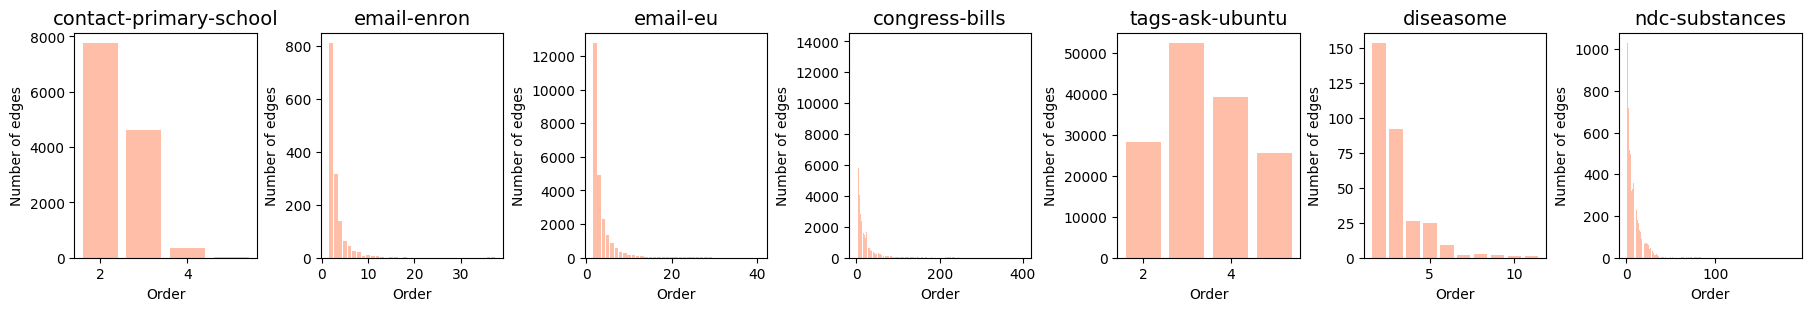

In [14]:
# -------------------------------------------------------------
# Plot hyperedge size distributions for all cleaned hypergraphs
# -------------------------------------------------------------

import matplotlib.pyplot as plt

# Step 1: Compute edge size counts for each dataset
Edge_size_count = []

for H in H_s:
    list_of_edge_sizes = H.edges.size.aslist()  # Get hyperedge sizes
    size_counts = {}
    
    for size in list_of_edge_sizes:
        if size not in size_counts:
            size_counts[size] = 1
        else:
            size_counts[size] += 1
    
    Edge_size_count.append(size_counts)

# Step 2: Set up the figure with subplots (1 row, len(H_s) columns)
fig, axes = plt.subplots(1, len(H_s), figsize=(18, 3), constrained_layout=True)

# Step 3: Plot each dataset
for i, ax in enumerate(axes):
    dic_sizes = Edge_size_count[i]
    
    # Bar plot of edge counts by size
    ax.bar(dic_sizes.keys(), dic_sizes.values(), color='coral', alpha=0.5)
    
    ax.set_title(files[i], fontsize=14)
    ax.set_xlabel('Order')
    ax.set_ylabel('Number of edges')
    
    print(f"{files[i]}: Max edge size = {max(dic_sizes.keys())}")

plt.show()


## Inter-Order overlap analysis

Here we calcualte the itner-order overlap for each data set.

In [18]:
# -------------------------------------------------------------
# Compute inter-order overlap matrices (alpha matrices) for each hypergraph
# -------------------------------------------------------------
from overlap_func import *

alphas_per_H = []  # List to store alpha matrices for all datasets

for i, H in enumerate(H_s):
    print('------------------------------------------------------------------')
    print(f"Dataset: {files[i]}")
    
    # Get hyperedge sizes
    T_sizes = H.edges.size.aslist()
    
    # Set maximum order for alpha computation (limit to 15 for large datasets)
    M_max = min(max(T_sizes), 15)
    
    # Compute the inter-order overlap matrix
    alphas = inter_order_overlap_alpha_matrix(H, max_order=M_max)
    
    # Store the result
    alphas_per_H.append(alphas)


------------------------------------------------------------------
Dataset: contact-primary-school
Max order: 5, Min order: 1
Computing overlaps for order 1/5
Computing overlaps for order 2/5
Computing overlaps for order 3/5
Computing overlaps for order 4/5
------------------------------------------------------------------
Dataset: email-enron
Max order: 15, Min order: 1
Computing overlaps for order 1/15
Computing overlaps for order 2/15
Computing overlaps for order 3/15
Computing overlaps for order 4/15
Computing overlaps for order 5/15
Computing overlaps for order 6/15
Computing overlaps for order 7/15
Computing overlaps for order 8/15
Computing overlaps for order 9/15
Computing overlaps for order 10/15
Computing overlaps for order 11/15
Computing overlaps for order 12/15
Computing overlaps for order 13/15
Computing overlaps for order 14/15
------------------------------------------------------------------
Dataset: email-eu
Max order: 15, Min order: 1
Computing overlaps for order 1/1

In [20]:
# Save each alpha matrix
for i, alpha in enumerate(alphas_per_H):
    output_path = f"overlap_matrices/alphas_H{i}.csv"
    np.savetxt(output_path, alpha, delimiter=",")
    print(f"Saved alpha matrix for dataset {files[i]} to {output_path}")

Saved alpha matrix for dataset contact-primary-school to overlap_matrices/alphas_H0.csv
Saved alpha matrix for dataset email-enron to overlap_matrices/alphas_H1.csv
Saved alpha matrix for dataset email-eu to overlap_matrices/alphas_H2.csv
Saved alpha matrix for dataset congress-bills to overlap_matrices/alphas_H3.csv
Saved alpha matrix for dataset tags-ask-ubuntu to overlap_matrices/alphas_H4.csv
Saved alpha matrix for dataset diseasome to overlap_matrices/alphas_H5.csv
Saved alpha matrix for dataset ndc-substances to overlap_matrices/alphas_H6.csv


In [21]:
# -------------------------------------------------------------
# Compute average inter-order overlap (alpha) for each hypergraph
# -------------------------------------------------------------

import numpy as np

average_alphas = []  # List to store average alpha values

# Helper function to check for NaN (optional; can use np.isnan directly)
def isNaN(num):
    return num != num

# Loop over all hypergraphs
for i, alphas in enumerate(alphas_per_H):
    
    # Compute average alpha, ignoring NaN values
    # np.nansum sums only the non-NaN elements
    # Divide by total number of elements for the average
    n_rows, n_cols = alphas.shape
    avg_alpha = np.nansum(alphas) / (n_rows * n_cols)
    
    average_alphas.append(avg_alpha)
    
    # Print dataset name and average alpha
    print(f"{files[i]}: Average alpha = {avg_alpha:.4f}")


contact-primary-school: Average alpha = 0.2618
email-enron: Average alpha = 0.0442
email-eu: Average alpha = 0.0500
congress-bills: Average alpha = 0.0105
tags-ask-ubuntu: Average alpha = 0.0679
diseasome: Average alpha = 0.0017
ndc-substances: Average alpha = 0.0042


In [22]:
# -------------------------------------------------------------
# Compute weighted average alpha for each hypergraph
# -------------------------------------------------------------

average_alphas = []  # List to store weighted average alpha values

def isNaN(num):
    """Check if a value is NaN."""
    return num != num

# Loop over all hypergraphs
for i, alphas in enumerate(alphas_per_H):
    dic_size = Edge_size_count[i]  # Dictionary: edge size -> count
    
    weighted_sum = 0
    total_weight = 0
    
    n_rows, n_cols = alphas.shape
    
    # Loop over all entries in the alpha matrix
    for j in range(n_rows):
        for k in range(n_cols):
            value = alphas[j, k]
            
            if isNaN(value):
                continue  # Skip NaN values
            
            # Weight by the number of edges of size j+2
            # (assuming j+2 matches the edge size indexing in dic_size)
            weight = dic_size.get(j + 2, 0)
            
            weighted_sum += value * weight
            total_weight += weight
    
    # Compute weighted average
    avg_alpha = weighted_sum / total_weight if total_weight > 0 else np.nan
    average_alphas.append(avg_alpha)
    
    print(f"{files[i]}: Weighted average alpha = {avg_alpha:.4f}")

contact-primary-school: Weighted average alpha = 0.8240
email-enron: Weighted average alpha = 0.3674
email-eu: Weighted average alpha = 0.3655
congress-bills: Weighted average alpha = 0.0451
tags-ask-ubuntu: Weighted average alpha = 0.1618
diseasome: Weighted average alpha = 0.0095
ndc-substances: Weighted average alpha = 0.0156


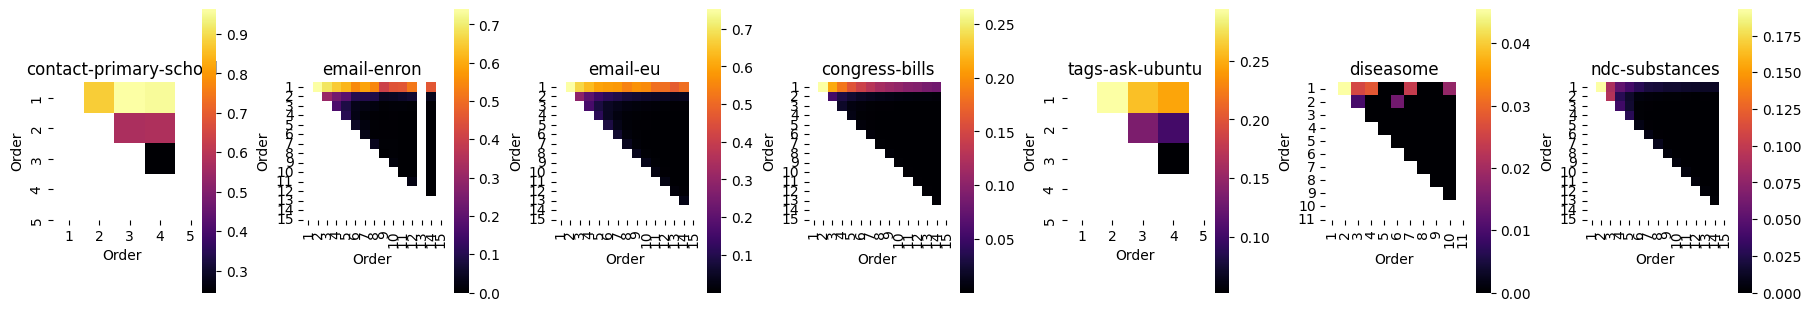

In [25]:
# -------------------------------------------------------------
# Plot inter-order overlap (alpha) matrices as heatmaps
# -------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Set up subplots: 1 row, len(H_s) columns
fig, axes = plt.subplots(1, len(H_s), figsize=(18, 3), constrained_layout=True)

# Positions for displaying average alpha on each subplot
list_positions = [[0.5, 4], [1, 12], [1, 12], [1, 12], [0.5, 4], [1, 9], [1, 12], [1, 12]]

# Loop over datasets and plot each heatmap
for i, ax in enumerate(axes):
    H = H_s[i]
    alphas = alphas_per_H[i]
    
    # Determine maximum order for display (cap at 15)
    T_sizes = H.edges.size.aslist()
    M_max = min(max(T_sizes), 15)
    
    # X and Y tick labels
    ticks = range(1, M_max + 1)
    
    # Plot heatmap
    sns.heatmap(
        alphas, 
        xticklabels=ticks,
        yticklabels=ticks,
        square=True,
        cmap="inferno",
        ax=ax
    )
    
    # Add title and labels
    ax.set_title(files[i], fontsize=12)
    ax.set_xlabel("Order")
    ax.set_ylabel("Order")
    
    # Annotate with average alpha
    x_pos, y_pos = list_positions[i]
    ax.text(
        x_pos, y_pos, 
        r'$\langle \alpha \rangle$ = ' + str(round(average_alphas[i], 2)),
        fontsize=12,
        color='white'
    )

plt.show()


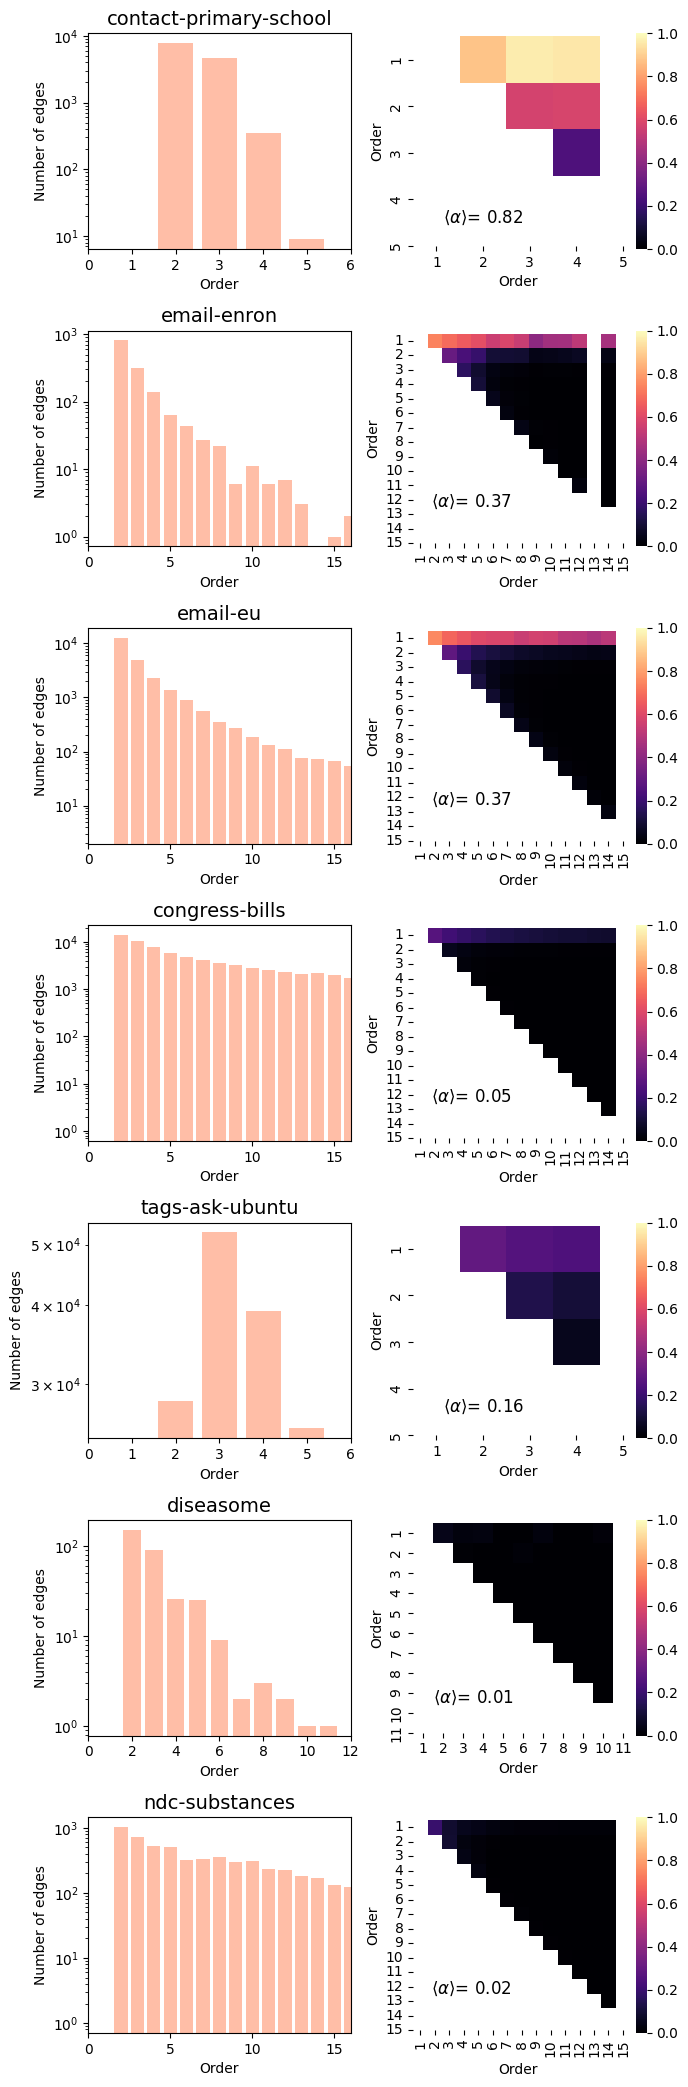

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
# Combined visualization: Hyperedge size distribution & alpha heatmap
# -------------------------------------------------------------

# Positions for annotating average alpha on each heatmap
list_positions = [[1.5, 4], [4, 12], [4, 12], [4, 12], [1.5, 4], [3, 9], [4, 12], [4, 12]]

# Create subplots: rows = number of datasets, columns = 2 (histogram + heatmap)
fig, axs = plt.subplots(len(H_s), 2, figsize=(7, 3 * len(H_s)))  # Dynamic height per dataset

# Ensure axs is always 2D for consistent indexing
if len(H_s) == 1:
    axs = axs.reshape(1, 2)

# Loop through each dataset
for i in range(len(H_s)):
    H = H_s[i]
    
    # Get hyperedge sizes and cap maximum order at 15
    T_sizes = H.edges.size.aslist()
    M_max = min(max(T_sizes), 15)
    
    # -------------------------------------------------------------
    # First Column: Bar plot of hyperedge size distribution
    # -------------------------------------------------------------
    axs[i, 0].set_title(files[i], fontsize=14)
    dic_sizes = Edge_size_count[i]  # Dictionary: edge size -> count
    axs[i, 0].bar(dic_sizes.keys(), dic_sizes.values(), color='coral', alpha=0.5)
    axs[i, 0].set_xlim((0, M_max + 1))
    axs[i, 0].set_xlabel('Order')
    axs[i, 0].set_ylabel('Number of edges')
    axs[i, 0].set_yscale('log')  # Use log scale for better visualization
    
    # -------------------------------------------------------------
    # Second Column: Heatmap of inter-order overlap (alpha)
    # -------------------------------------------------------------
    x = range(1, M_max + 1)
    y = range(1, M_max + 1)
    
    # Plot heatmap
    sns.heatmap(
        alphas_per_H[i],
        xticklabels=x,
        yticklabels=y,
        square=True,
        cmap="magma",
        vmin=0,
        vmax=1,
        ax=axs[i, 1]
    )
    
    # Annotate heatmap with weighted average alpha
    axs[i, 1].text(
        list_positions[i][0],
        list_positions[i][1],
        r'$\langle \alpha \rangle$= ' + str(round(average_alphas[i], 2)),
        fontsize=12,
        ha="center"
    )
    
    axs[i, 1].set_xlabel('Order')
    axs[i, 1].set_ylabel('Order')

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()


In [32]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap


min_sat=0.1
# Use a truncated version of 'Greens' that starts at a more saturated green
cmap_Greens = truncate_colormap(cm.get_cmap('Greens'), minval=min_sat)
cmap_Greens.set_bad('white',0.2)
                                
cmap_Oranges = truncate_colormap(cm.get_cmap('Oranges'), minval=min_sat)
cmap_Oranges.set_bad('white',0.2)
cmap_Blues = truncate_colormap(cm.get_cmap('Blues'), minval=min_sat)
cmap_Blues.set_bad('white',alpha=0.2)
cmap_Reds = truncate_colormap(cm.get_cmap('Reds'), minval=min_sat)
cmap_Reds.set_bad('white',0.2)

C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_13996\535506848.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_Greens = truncate_colormap(cm.get_cmap('Greens'), minval=min_sat)
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_13996\535506848.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_Oranges = truncate_colormap(cm.get_cmap('Oranges'), minval=min_sat)
C:\Users\jg3509phd\AppData\Local\Temp\ipykernel_13996\535506848.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)

### Final plot

Here is the code used to generate ther final plot used to create the figure in the supplementary material. For this one we used just 4 out of the 7 samples studied. 

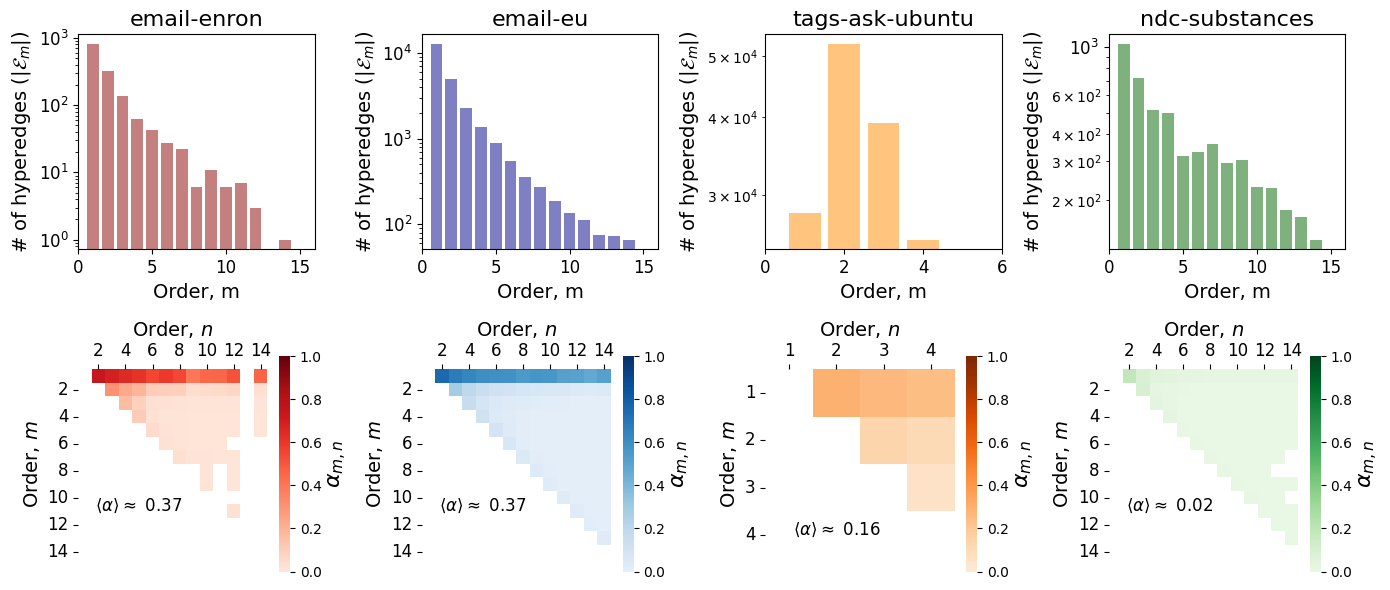

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------------------------------------
# Visualization for selected real datasets:
# Top row: Hyperedge size distributions
# Bottom row: Inter-order overlap (alpha) heatmaps
# -------------------------------------------------------------

# Selected datasets for final visualization
final_data_sets = ['email-enron', 'email-eu','tags-ask-ubuntu','ndc-substances']
files = ['contact-primary-school', 'email-enron', 'email-eu', 'congress-bills',
         'tags-ask-ubuntu','diseasome', 'ndc-substances']

# Colors and colormaps for heatmaps and bar plots
colors = ['darkred', 'darkblue', 'darkorange', 'darkgreen']
cmaps = [cmap_Reds, cmap_Blues, cmap_Oranges, cmap_Greens]

# Indices of final datasets in H_s/files
id_final_data = [1, 2, 4, 6]

# Positions for average alpha annotation on heatmaps
list_positions = [[4, 12], [4, 12], [1.5, 4], [4, 12]]

# Create a 2-row figure: 1st row = histograms, 2nd row = heatmaps
fig, axs = plt.subplots(2, len(final_data_sets), figsize=(14, 6))  # Dynamic width

# Counter for column indexing
c = 0

# Loop over selected datasets
for i in id_final_data:
    H = H_s[i]
    
    # Extract hyperedge sizes and cap maximum order for display
    T_sizes = H.edges.size.aslist()
    M_max = min(max(T_sizes), 15)

    # -------------------------------------------------------------
    # First Row: Histogram of hyperedge size distribution
    # -------------------------------------------------------------
    axs[0, c].set_title(files[i], fontsize=16)
    dic_sizes = Edge_size_count[i]
    
    # Keep only hyperedges of order <= 15
    dic_sizes_cut = {order: dic_sizes[order] for order in dic_sizes.keys() if order <= 15}
    
    # Plot bar chart
    axs[0, c].bar(np.array(list(dic_sizes_cut.keys())[:14]) - 1,  # shift for alignment
                  list(dic_sizes_cut.values())[:14],
                  color=colors[c], alpha=0.5)
    
    axs[0, c].set_xlim((0, M_max + 1))
    axs[0, c].set_xlabel('Order, m', fontsize=14)
    axs[0, c].set_ylabel(r'# of hyperedges ($|\mathcal{E}_m|$)', fontsize=14)
    axs[0, c].set_yscale('log')  # Log scale for better visualization
    axs[0, c].tick_params(axis='both', labelsize=12)

    # -------------------------------------------------------------
    # Second Row: Heatmap of inter-order overlap (alpha)
    # -------------------------------------------------------------
    alpha = alphas_per_H[i].copy()  # Work on a copy to avoid modifying original
    alpha[alpha == 0] = np.nan  # Mask zero values for visualization
    
    x = range(1, M_max)
    y = range(1, M_max)
    
    hm = sns.heatmap(
        alpha,
        xticklabels=x,
        yticklabels=y,
        square=True,
        cmap=cmaps[c],
        vmin=0,
        vmax=1,
        ax=axs[1, c]
    )
    
    # Add colorbar label
    cbar = axs[1, c].collections[0].colorbar
    cbar.set_label(r'$\alpha_{m,n}$', fontsize=16)
    
    # Annotate heatmap with weighted average alpha
    axs[1, c].text(
        M_max * 0.3,
        M_max * 0.7,
        r'$\langle \alpha \rangle \approx $ ' + str(round(average_alphas[i], 2)),
        fontsize=12,
        ha="center"
    )
    
    # Axis labels
    axs[1, c].set_xlabel(r'Order, $n$', fontsize=14)
    axs[1, c].set_ylabel(r'Order, $m$', fontsize=14)
    
    # Configure ticks
    xticks = list(range(2, M_max)) if c != 2 else list(range(1, M_max))
    xticks_to_show = xticks[::2] if c != 2 else xticks
    axs[1, c].set_xticks(np.array(xticks_to_show) - 0.5)
    axs[1, c].set_xticklabels(xticks_to_show, rotation=0, fontsize=12)
    
    yticks = list(range(2, M_max)) if c != 2 else list(range(1, M_max))
    yticks_to_show = yticks[::2] if c != 2 else yticks
    axs[1, c].set_yticks(np.array(yticks_to_show) - 0.5)
    axs[1, c].set_yticklabels(yticks_to_show, rotation=0, fontsize=12)
    
    # Place x-axis on top for heatmap
    axs[1, c].xaxis.set_ticks_position('top')
    axs[1, c].xaxis.set_label_position('top')
    
    # Increment column counter
    c += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Save figure
plt.savefig('HG_real_nets.pdf', dpi=300)
plt.show()
